<img src="python_ecosystem.png" width=600px />

(image: Ondřej Čertík)

# Vectorization 101

In [1]:
import numpy as np

`vectorization` refers to a programming style where you use numpy's ability to operate on whole arrays at once, instead of using explicit for-loops.

## All-array operations

In [2]:
a = np.array([1., 2., 3., 4., 5., 6., 7., 8.])

### First of all, it's convenient

In [3]:
# "standardize" an array

(a - a.mean()) / a.std()

array([-1.52752523, -1.09108945, -0.65465367, -0.21821789,  0.21821789,
        0.65465367,  1.09108945,  1.52752523])

Compare to

In [4]:
lst = [1., 2., 3., 4., 5., 6., 7., 8.]

from math import sqrt

a_mean = sum(lst) / len(lst)
a_std = sqrt(sum((x - a_mean)**2 for x in lst) / len(lst))

[(x - a_mean) / a_std for x in lst]

[-1.5275252316519468,
 -1.091089451179962,
 -0.6546536707079772,
 -0.2182178902359924,
 0.2182178902359924,
 0.6546536707079772,
 1.091089451179962,
 1.5275252316519468]

#### Array attributes vs numpy namespace functions

For historical reasons, some functionality is available as both ways, e.g., `a.mean()` and `np.mean(a)`, but some is not. For example, `np.median(a)`, but not `a.median()`.

Do check the NumPy manual, https://docs.scipy.org/doc/numpy/reference/

### Second, it's faster.

One more (artificial) example:

In [5]:
a = np.array([1., 2., 3., 4., 5., 6., 7., 8.])
b = a**2  + np.sin(a)
b

array([ 1.84147098,  4.90929743,  9.14112001, 15.2431975 , 24.04107573,
       35.7205845 , 49.6569866 , 64.98935825])

The following is an exact equivalent:

In [6]:
from math import sin

b = np.zeros(30)
for i in range(len(a)):
    b[i] = a[i]**2 + sin(a[i])

Why bothering: let's time it.

In [7]:
%timeit b = a**2 + np.sin(a)

4.23 µs ± 34.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
%%timeit
for i in range(len(a)):
    b[i] = a[i]**2 + sin(a[i])

18.2 µs ± 287 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
8.35 / 2.83

2.9505300353356887

On my laptop the vectorized form is faster by a factor of about 3. The difference increases as your arrays get larger.

Notice how numpy's `sin` function operates on the whole array elementwise. This is a typical behavior of the universal functions, `ufuncs`.  

### One more example: let's threshold an array.

In [10]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
a[a <= 4] = -101
a

array([-101, -101, -101, -101, -101,    5,    6,    7,    8,    9])

In [12]:
(2 < a) & (a <= 7)

array([False, False, False, False, False,  True,  True,  True, False,
       False])

# *Cochleoid*

In polar coordinates
$$
r = \frac{\sin{\phi}}{\phi}
$$

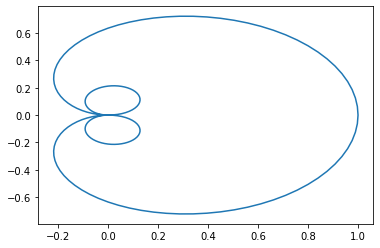

In [66]:
phi = np.linspace(-2*np.pi, 2*np.pi, 201)

phi = phi[phi != 0]
r = np.sin(phi) / phi

x = r * np.cos(phi)
y = r * np.sin(phi)

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()

# Internals of an np.array

In [14]:
a = np.arange(8).reshape((2, 4))
a

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [15]:
a.data

In [16]:
a.dtype

dtype('int32')

In [17]:
a.ndim

2

In [18]:
a.shape

(2, 4)

In [19]:
a.strides

(16, 4)

## Arrays can be reshaped in $O(1)$ in time and memory

In [20]:
a = np.arange(10)

a.shape

(10,)

In [21]:
a.reshape(2, -1)

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [22]:
b = a.reshape(-1, 2)
b

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

# The power of slicing

From a student's email:

> A general issue of speed for the overall program. A single run with sufficient data points is taking about 2-3 weeks.


Neighborhood averages of a two-dim array.


In [23]:
# set up an array

m, n = 4, 4
a = np.arange(m*n, dtype=np.float).reshape((m, n))
a

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

First, a non-vectorized code:

In [24]:
b = np.zeros((m-1, n-1))
for i in range(m-1):
    for j in range(n-1):
        b[i, j] = a[i, j] + a[i+1, j] + a[i, j+1] + a[i+1, j+1]
b

array([[10., 14., 18.],
       [26., 30., 34.],
       [42., 46., 50.]])

Now use the fact that for each axis of the array,
- indexing starts from 0,
- negative indices mean counting from the end, and
- indexing can be done by `slices`, which are half-open: `a[start:stop]` is a sub-array of `a`, which contains `a[start]`, `a[start+1]` and so on, up to and *excluding* `a[stop]`.

This way, for a 1D array `a`, `a[0]` is the first element, `a[-1]` is the last element, and `a[1:3]` is `[a[1], a[2]]`.

Also notice that if `start` is zero, it can be omitted, so that `a[0:3]` and `a[:3]` are equivalent. Ditto for the maximum value of `stop`.

Armed with this, here's a vectorized form of the double loop above:

In [25]:
b_vect = a[:-1, :-1] + a[1:, :-1] + a[:-1, 1:] + a[1:, 1:]

In [26]:
b_vect == b

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [27]:
m, n = 50, 50
a = np.arange(m*n, dtype=float).reshape((m, n))

In [28]:
%timeit a[:-1, :-1] + a[1:, :-1] + a[:-1, 1:] + a[1:, 1:]

34.7 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
%%timeit

for i in range(m-1):
    for j in range(n-1):
        a[i, j] + a[i+1, j] + a[i, j+1] + a[i+1, j+1]

5.91 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Conway's game of life

Cells live on a square grid. Each cell can be in either of two states: alive or dead. Cells interact with nearest neighbors.

At each *tick*, 

- Any live cell with `<2` neighbors dies, as if of underpopulation.
- Any live cell with `>3` neighbors dies, as if of overpopulation.
- Any dead cell with `=3` neighbors becomes a live cell, as if by reproduction.

From a cell-centric view to a whole-array formulation: for each cell, consider the sum of nine fields.
- If the sum `= 3`, central cenral cell's state is life.
- If the sum `= 4`, the state of the central cell does not change
- Otherwise, it dies.

In [30]:
def step(X):
    """Given a game board ``X``, make a time step and return the result.
    
    NB: In this implementation the game field is finite.

    """
    num_neighb = (X[:-2, :-2]  + X[1:-1, :-2]  + X[2:, :-2] +
                  X[:-2, 1:-1] + X[1:-1, 1:-1] + X[2:, 1:-1] +
                  X[:-2, 2:]   + X[1:-1, 2:]   + X[2:, 2:])
    
    X[1:-1, 1:-1][num_neighb == 3] = 1
    X[1:-1, 1:-1][(num_neighb != 4) & (num_neighb != 3)] = 0
    return X

# https://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/

# Broadcasting

Overheard on the numpy-discussion mailing list at some point:

OP:

> I personally think that silent Broadcasting is not a good thing. I had recently a lot of trouble with row and column vectors which got bradcastet toghether ...

Chuck Harris (numpy RM):

> It's how numpy works. 

In [31]:
a = np.arange(8).reshape((2, 4))
a

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [32]:
b = np.arange(4, 0, -1)
b

array([4, 3, 2, 1])

In [33]:
a - b

array([[-4, -2,  0,  2],
       [ 0,  2,  4,  6]])

The formal rule: Given two arrays, `S` and `P`, with shapes

$$
    \begin{aligned}
        \mathrm{S.shape} &= (\cdots, s_3, s_2, s_1) \\
        \mathrm{P.shape} &= (\cdots, p_3, p_2, p_1)
    \end{aligned}
$$

broadcasting works from the right backwards:

* If the number of dimensions of `S` and `P` is different, left-pad the smaller shape with ones.

* If $s_j = 1$ and $p_j \neq 1$, the corresponding axis of the `S` array is treated as if it were expanded to have $p_j$ elements.

* If $s_j \neq p_j \neq 1$, it's an error.

In [34]:
x = np.arange(5)
x

array([0, 1, 2, 3, 4])

In [35]:
x[:, None]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [36]:
print(x.shape, x[:, None].shape, x[None, :].shape)

(5,) (5, 1) (1, 5)


In [37]:
x + x[:, None]

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8]])

# Universal functions, a.k.a. `ufuncs`

Universal functions of a single argument receive an array and work elementwise. Binary functions broadcast their arguments against each other and _then_ work elementwise.

In [38]:
a = np.arange(7)

np.add(a, a)

array([ 0,  2,  4,  6,  8, 10, 12])

In [39]:
a = np.arange(7)

np.multiply(a, a)

array([ 0,  1,  4,  9, 16, 25, 36])

### In-place operations

In [40]:
a = np.arange(7)

np.add(a, a, out=a)    # note the `out` kwarg

a

array([ 0,  2,  4,  6,  8, 10, 12])

### N.B.

`np.multiply` is **elementwise** multiplication. For matrix multiplication, use the `@` operator.

In [41]:
a = np.ones(9).reshape((3, 3))

a * a

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [42]:
a @ a

array([[3., 3., 3.],
       [3., 3., 3.],
       [3., 3., 3.]])

`Ufuncs` have (sometimes) useful methods.

### `np.add.<TAB>`

- `np.add.reduce` is `np.sum`

- `np.add.accumulate` is `np.cumsum`

- `np.add.outer` has the outer-product semantics

## Example: construct a Cauchy matrix

Given two vectors, $\vec{u}$ and $\vec{v}$, 

$$
C_{jk} = \frac{1}{u_j - v_k}
$$

In [43]:
np.set_printoptions(precision=3)    # pretty up printing

u = np.arange(4)
v = u + 0.5
    
A_ = np.zeros((len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        A_[i, j] = 1. / (u[i] - v[j])
A_

array([[-2.   , -0.667, -0.4  , -0.286],
       [ 2.   , -2.   , -0.667, -0.4  ],
       [ 0.667,  2.   , -2.   , -0.667],
       [ 0.4  ,  0.667,  2.   , -2.   ]])

Now, construct the Cauchy matrix using numpy constructs. Do it two ways: using broadcasting and using `subtract.outer` 

In [44]:
# using broadcasting
u = np.arange(4)
v = u + 0.5

cauchyM = 1 / (u.reshape((-1,1)) - v)
cauchyM

array([[-2.   , -0.667, -0.4  , -0.286],
       [ 2.   , -2.   , -0.667, -0.4  ],
       [ 0.667,  2.   , -2.   , -0.667],
       [ 0.4  ,  0.667,  2.   , -2.   ]])

In [45]:
# using subtract.outer
u = np.arange(4)
v = u + 0.5

cauchy = 1 / np.subtract.outer(u.reshape((-1,1)), v)
cauchy

array([[[-2.   , -0.667, -0.4  , -0.286]],

       [[ 2.   , -2.   , -0.667, -0.4  ]],

       [[ 0.667,  2.   , -2.   , -0.667]],

       [[ 0.4  ,  0.667,  2.   , -2.   ]]])

## Stack your vectors (to N-D and beyond)

Things get more interesting when dealing with multidimensional arrays. 

Suppose we have a collection of vectors on a two-dimensional plane, and we represent them as two-element numpy arrays:

In [46]:
x1 = np.array([1., 1.])
x2 = np.array([4., -3.])
x3 = np.array([8., 0.])

Note that in numpy-speak, these are *one-dimensional arrays*  

In [47]:
x1.ndim

1

of shape (2,)

In [48]:
x1.shape

(2,)

Suppose that we want to calculate lengths of these vectors. For a single vector it's easy:

In [49]:
def norm(vect):
    """Compute an absolute value of a 2-d vector, represented as a 1-d numpy array."""
    return np.sqrt(vect[0]**2 + vect[1]**2)

Now it's also easy to loop over the vectors,

In [50]:
[norm(v) for v in (x1, x2, x3)]

[1.4142135623730951, 5.0, 8.0]

... but there is a better, vectorized way.

First, we stack our vectors together into a 3-by-2 array (or produce this array in a first place.)

In [51]:
x = np.vstack([x1, x2, x3])
x

array([[ 1.,  1.],
       [ 4., -3.],
       [ 8.,  0.]])

In [52]:
x.shape

(3, 2)

OK, squaring is an elementwise operation:

In [53]:
x**2

array([[ 1.,  1.],
       [16.,  9.],
       [64.,  0.]])

Now to imitate the `norm` function above, we need to sum the elements in each row of `x**2` --- in the numpy-speak, it's a sum along the second axis:

In [54]:
np.sum(x**2, axis=1)

array([ 2., 25., 64.])

Collecting this all together:

In [55]:
def norm_vect(xx):
    """Given a stack of d-dimensional vectors, compute their lengths.

    Parameters
    ----------
    xx : array_like, shape (m, d)
        Each row of `xx` represents a vector in d-dimensional space.

    Returns
    -------
    lengths : array_like, shape (d,)
        Euclidean lengths of the vectors
    """
    xx = np.asarray(xx)
    assert xx.ndim == 2   # safeguard
    nrm = np.sum(xx**2, axis=1)
    return np.sqrt(nrm)

In [56]:
norm_vect(x)

array([1.414, 5.   , 8.   ])

## Linear algebra with [numpy.linalg](https://docs.scipy.org/doc/numpy/reference/routines.linalg.html)

In [57]:
x = 1 + np.arange(3)
A = x + x[:, None]
A = A @ A.T

np.linalg.det(A)

3.136498153398487e-14

In [58]:
rhs = np.ones(3)
np.linalg.solve(A, rhs)

array([ 2.259e-03,  2.495e+00, -1.998e+00])

## Random number generation with [numpy.random](https://docs.scipy.org/doc/numpy/reference/routines.random.html)

In [59]:
np.random.seed(1234)    # For reproducibility, consider seeding your generator
np.random.random(size=10)

array([0.192, 0.622, 0.438, 0.785, 0.78 , 0.273, 0.276, 0.802, 0.958,
       0.876])

`np.random` provides a global stream of pseudo-random numbers. Under the hood, there is a single, global  `RandomState` object. In real code prefer using explicit `RandomState` objects

In [60]:
rndm = np.random.RandomState(1234)
rndm.uniform(size=11)

array([0.192, 0.622, 0.438, 0.785, 0.78 , 0.273, 0.276, 0.802, 0.958,
       0.876, 0.358])

In [61]:
rndm.normal(loc=0, scale=8, size=11)

array([16.02 ,  0.087, -6.954, 11.4  ,  1.166, 23.153, -2.434,  6.893,
       -5.519,  1.5  ,  4.834])

# (Some) `numpy` gotchas

#### `numpy` gotchas for python users

`lst[:]` is a copy of `lst`

`arr[:]` is a *view* into `arr` (for copying use `arr.copy()`)

#### `numpy` gotchas for pandas users

In [62]:
a = np.array([np.nan, 2., 3.])

import pandas as pd
s = pd.Series(a)

In [63]:
s.sum()

5.0

In `numpy`, NaN means "invalid" not "missing".

In [64]:
a.sum()

nan

In [65]:
np.nansum(a)

5.0

#### never do `from numpy import *`

See [Exercise 26](https://github.com/rougier/numpy-100/blob/master/100%20Numpy%20exercises.md#26-what-is-the-output-of-the-following-script-) of Numpy 100 exercises.

# Further reading

Numpy docs http://docs.scipy.org/doc/numpy/reference/index.html

Nicolas Rougier, *From Python to Numpy*, https://www.labri.fr/perso/nrougier/from-python-to-numpy/
    
Jake Vanderplas' *Numpy Intro*
http://nbviewer.ipython.org/github/jakevdp/2013_fall_ASTR599/blob/master/notebooks/05_NumpyIntro.ipynb

and *Efficient Numpy* http://nbviewer.ipython.org/github/jakevdp/2013_fall_ASTR599/blob/master/notebooks/11_EfficientNumpy.ipynb

or *Loosing your loops*
https://speakerdeck.com/jakevdp/losing-your-loops-fast-numerical-computing-with-numpy-pycon-2015

Pauli Virtanen, *Advanced Numpy* (Scipy lecture notes)
https://scipy-lectures.github.io/

Nicolas Rougier, *100 Numpy exercises*
https://github.com/rougier/numpy-100/